## Training to velocities, 1st derivatives and laplacians

In [5]:
n_params = 0


l=2
filt = 3
k=16

n_params += (l*filt+1)*k

for i in range(3):
    l=16
    n_params += (l*filt+1)*k
    
l=16
k=2
n_params += (l*filt+1)*k

print("Number of parameters: " + str(n_params))

bits = n_params*32

print("Bits: " + str(bits))

print("Bytes: " + str(int(bits/8)))

Number of parameters: 2562
Bits: 81984
Bytes: 10248


In [7]:
10_000_000*4*4

160000000

In [1]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
import jax_cfd.ml.diego_preprocessing as preprocessing
import jax_cfd.ml.diego_train_functions as training
from jax_cfd.ml import nonlinearities
import jax_cfd.ml.diego_cnn_bcs as bcs

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

import matplotlib.pyplot as plt
import seaborn

import time

In [2]:
# this allows me to reload a module without having to interrupt the kernel
import importlib
importlib.reload(preprocessing)
# importlib.reload(from jax_cfd.ml.diego_train_functions import *)
# importlib.reload(from jax_cfd.ml import nonlinearities)
# importlib.reload(from jax_cfd.ml.diego_cnn_bcs import *)

<module 'jax_cfd.ml.diego_preprocessing' from '/rds/general/user/dd519/home/FYP/forked_jax/jax-cfd/jax_cfd/ml/diego_preprocessing.py'>

In [3]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [4]:
# import data
file_name = '1080x256_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [5]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape)
    ])
    high_def.append(this_time)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 5 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 50
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.003703703703703704
outer_steps: 	40499
inner_steps: 	1.0
total_sim_time: 149.9962962962963
removed points: 1350


step = 50
Training dataset shape: 
	(783, 1080, 256, 2)


In [7]:
# %time high_def_norm,ogMean,ogStdDev = preprocessing.normalisingDataset(high_def)
high_def_norm = high_def

## Defining what we are training towards

In [8]:
which_outputs = {
        "vels" : False,
        "derivatives" : False,
        "laplacians" : True
    }

In [12]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = preprocessing.creatingDataset(high_def_norm,preprocessing.sampling,factor)

print("\nCreate Y dataset: ")
padding = [1,1]
%time Y_dataset = preprocessing.getYdata(high_def_norm,which_outputs,padding,preprocessing.sampling,factor) #does everything, returns unpadded data

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]



# print("\nPadding all datasets: ")
# padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
# %time X_train = padXDataset(X_train,padding)
# %time Y_train = padYDatasetNew(Y_train,padding,conditions)

# %time X_test = padXDataset(X_test,padding)
# %time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
training.printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 183 ms, sys: 1.92 ms, total: 185 ms
Wall time: 185 ms

Create Y dataset: 
CPU times: user 24.5 s, sys: 92.5 ms, total: 24.6 s
Wall time: 24.7 s

Shapes of all datasets
(742, 64, 16, 2)
(742, 64, 16, 2)
(186, 64, 16, 2)
(186, 64, 16, 2)


## Defining model shape

In [13]:
def ConvNet(x):
    cnn = mytowers.CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 10,
    "hidden_layers" : 6,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [14]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [15]:
instance = training.MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(42), #rng_key
                      input_channels=2,
                      epochs = 25,
                      printEvery=1,#epochs
                      learning_rates=training.staggeredLearningRate((50,0.1),(20,0.01),(11,0.001)), #iterated over batches
                      batch_size=len(X_train)//2+1, # number or len(X_train)
                      validateEvery=1,
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(742, 64, 16, 2)
(742, 64, 16, 2)
(186, 64, 16, 2)
(186, 64, 16, 2)



Start time: 19:12:07
Epoch 1/25
	mse : 0.000800		val mse : 0.000769	Estimated end time: 19:26:33


Epoch 2/25
	mse : 0.000751		val mse : 0.000731	Estimated end time: 19:31:07


Epoch 3/25
	mse : 0.000721		val mse : 0.000709	Estimated end time: 19:33:20


Epoch 4/25
	mse : 0.000703		val mse : 0.000695	Estimated end time: 19:34:44


Epoch 5/25
	mse : 0.000692		val mse : 0.000686	Estimated end time: 19:35:35


Epoch 6/25
	mse : 0.000685		val mse : 0.000680	Estimated end time: 19:36:14


Epoch 7/25
	mse : 0.000681		val mse : 0.000677	Estimated end time: 19:36:41


Epoch 8/25
	mse : 0.000678		val mse : 0.000674	Estimated end time: 19:37:05


Epoch 9/25
	mse : 0.000675		val mse : 0.000672	Estimated end time: 19:37:23


Epoch 10/25
	mse : 0.000674		val mse : 0.000671	Estimated end time: 19:37:38


Epoch 11/25
	mse : 0.000672		val mse : 0.000669	Estimated end time: 19:37:50


Epoch 12/25
	mse : 0.0006

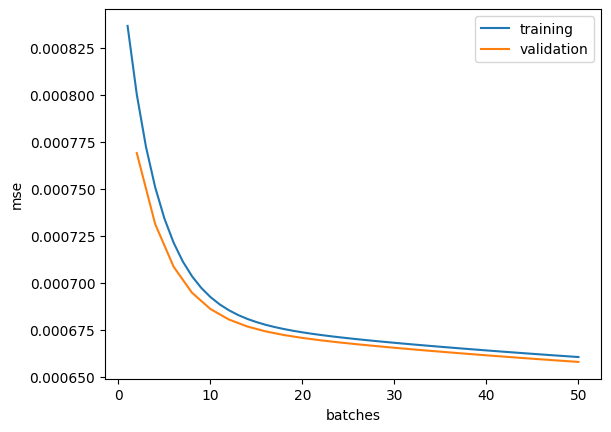

In [16]:

batches = np.arange(len(instance.losses))
val_step = len(instance.losses)//len(instance.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,instance.losses, label="training")
plt.plot(batches_val,instance.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [17]:
description = "27 mins, wide and deep network"

In [18]:
toSave = saving.newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [20]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

del save_path

In [25]:
del save_path

In [21]:
save_path = "./../models/correctors/laplacian_correctors/best_laplacian.pickle"

## Loading model

In [22]:
import pickle
import jax_cfd.ml.newSaveObject as saving
import haiku as hk

In [23]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [24]:
loaded.description

'27 mins, wide and deep network'

## Evaluating the model 

In [26]:
# loss_eval = mse
def loss_eval(in1,in2):
    return abs(in1-in2)

In [27]:
# Make predictions for every slice in X_test
predictions = []
for mySlice in X_test:
    predictions.append(loaded.forward_pass.apply(loaded.params,mySlice))

In [28]:
# Compute error predictions vs Y_test
errors = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(predictions[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errors.append(partial)

In [29]:
# Compute what would have been obtained from input without the CNN (to see if there is an improvement)

In [30]:
# calculate laplacians for input
inputLaps = []
for j in range(len(X_test)):
    inputLaps.append(preprocessing.npLaplacian(X_test[j]))

In [31]:
# Compute error computed laps for input vs true laps
errorsLaps = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(inputLaps[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errorsLaps.append(partial)

In [32]:
print("Test error for NN")
print("\tError : {:.6f}".format(np.mean(errors)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errors) / np.mean(np.abs(Y_test))))

print("\nError if no NN used")
print("\tError : {:.6f}".format(np.mean(errorsLaps)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errorsLaps) / np.mean(np.abs(Y_test))))

Test error for NN
	Error : 0.012113
	Error/mean(||truth||) : 1.285710

Error if no NN used
	Error : 0.050160
	Error/mean(||truth||) : 5.324040
